# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

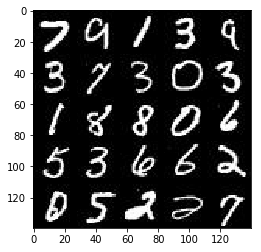

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

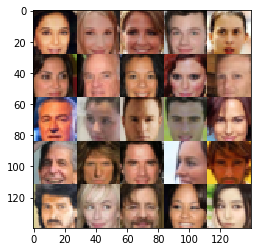

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    keep_prob = 0.8
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        relu1 = tf.maximum(alpha * x1, x1)
    
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        bn2 = tf.nn.dropout(bn2, keep_prob=keep_prob)
        relu2 = tf.maximum(alpha * bn2, bn2)
       
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        bn3 = tf.nn.dropout(bn3, keep_prob=keep_prob)
        relu3 = tf.maximum(alpha * bn3, bn3)
      
        flat = tf.reshape(relu3, (-1, 4*4*512))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2

    with tf.variable_scope('generator',reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
       
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every=10
    show_every = 100
    n_images = 50
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate, input_real: batch_images})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.2035... Generator Loss: 0.0997
Epoch 1/2... Discriminator Loss: 0.4956... Generator Loss: 13.0643
Epoch 1/2... Discriminator Loss: 1.9238... Generator Loss: 12.1849
Epoch 1/2... Discriminator Loss: 0.5436... Generator Loss: 3.1171
Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 5.4642
Epoch 1/2... Discriminator Loss: 2.2931... Generator Loss: 0.4321
Epoch 1/2... Discriminator Loss: 1.4644... Generator Loss: 1.0440
Epoch 1/2... Discriminator Loss: 2.2154... Generator Loss: 0.3483
Epoch 1/2... Discriminator Loss: 1.4999... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 1.6551... Generator Loss: 0.4537


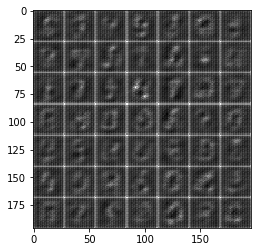

Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 1.9224... Generator Loss: 0.3519
Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 1.0988
Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 2.0555
Epoch 1/2... Discriminator Loss: 1.1306... Generator Loss: 1.3088
Epoch 1/2... Discriminator Loss: 1.2686... Generator Loss: 0.9191
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.5738
Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 1.2126
Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 1.0619
Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 1.3487


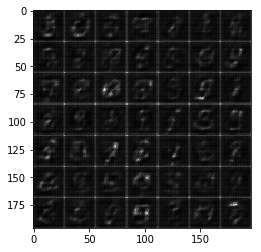

Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.6614
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 1.3577
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.7455
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 0.9075
Epoch 1/2... Discriminator Loss: 1.0138... Generator Loss: 1.0454
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 1.5285
Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 1.5139
Epoch 1/2... Discriminator Loss: 0.9601... Generator Loss: 1.4915
Epoch 1/2... Discriminator Loss: 2.0615... Generator Loss: 0.3047
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 2.1004


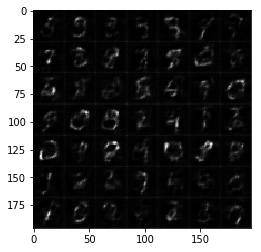

Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 0.9582
Epoch 1/2... Discriminator Loss: 1.2733... Generator Loss: 0.9342
Epoch 1/2... Discriminator Loss: 1.7468... Generator Loss: 0.4896
Epoch 1/2... Discriminator Loss: 1.7120... Generator Loss: 0.4922
Epoch 1/2... Discriminator Loss: 1.4042... Generator Loss: 0.6096
Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.0843... Generator Loss: 1.3841
Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 0.7147
Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 1.1778
Epoch 1/2... Discriminator Loss: 1.6037... Generator Loss: 2.0394


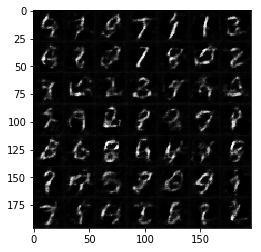

Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 0.7632
Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 0.9018
Epoch 1/2... Discriminator Loss: 1.5112... Generator Loss: 0.5353
Epoch 1/2... Discriminator Loss: 1.3718... Generator Loss: 0.5992
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 1.1135
Epoch 1/2... Discriminator Loss: 1.0078... Generator Loss: 0.9219
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 1.3487
Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 1.0458... Generator Loss: 1.1425
Epoch 1/2... Discriminator Loss: 1.3237... Generator Loss: 0.6481


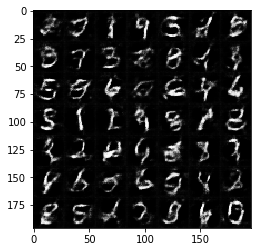

Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 1.1593... Generator Loss: 1.0194
Epoch 1/2... Discriminator Loss: 1.1757... Generator Loss: 1.1287
Epoch 1/2... Discriminator Loss: 1.2317... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.5939
Epoch 1/2... Discriminator Loss: 1.4630... Generator Loss: 0.5242
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 0.7490
Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 0.9971
Epoch 1/2... Discriminator Loss: 1.1924... Generator Loss: 0.8823


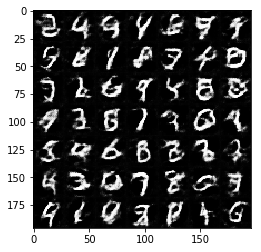

Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 0.8788
Epoch 1/2... Discriminator Loss: 1.0635... Generator Loss: 1.4540
Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 0.8921
Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 0.9908
Epoch 1/2... Discriminator Loss: 1.6321... Generator Loss: 0.4418
Epoch 1/2... Discriminator Loss: 1.1126... Generator Loss: 1.3560
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.6837
Epoch 1/2... Discriminator Loss: 1.0448... Generator Loss: 1.9797
Epoch 1/2... Discriminator Loss: 1.2982... Generator Loss: 1.9826
Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 0.9740


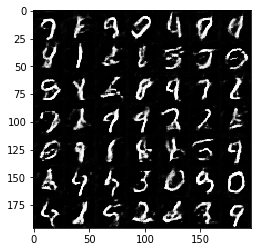

Epoch 1/2... Discriminator Loss: 1.4747... Generator Loss: 0.5458
Epoch 1/2... Discriminator Loss: 1.1488... Generator Loss: 1.2914
Epoch 1/2... Discriminator Loss: 1.2500... Generator Loss: 0.7696
Epoch 1/2... Discriminator Loss: 1.2819... Generator Loss: 0.8237
Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 1.2094... Generator Loss: 0.7392
Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 1.3815
Epoch 1/2... Discriminator Loss: 0.9533... Generator Loss: 1.2312
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.8762
Epoch 1/2... Discriminator Loss: 1.3894... Generator Loss: 0.5978


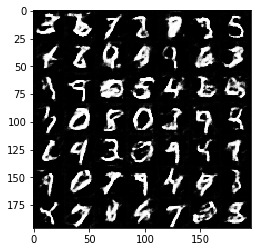

Epoch 1/2... Discriminator Loss: 1.0300... Generator Loss: 1.1269
Epoch 1/2... Discriminator Loss: 1.0013... Generator Loss: 1.0951
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 1.6850
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 1.7318
Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 0.8100
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 0.6862
Epoch 1/2... Discriminator Loss: 1.1201... Generator Loss: 2.0792
Epoch 1/2... Discriminator Loss: 1.2375... Generator Loss: 1.3483
Epoch 1/2... Discriminator Loss: 1.1823... Generator Loss: 0.7252
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 0.7247


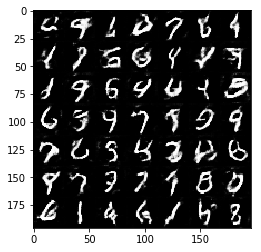

Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 1.3265
Epoch 1/2... Discriminator Loss: 1.9164... Generator Loss: 2.9019
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 0.7590
Epoch 2/2... Discriminator Loss: 0.9872... Generator Loss: 1.2349
Epoch 2/2... Discriminator Loss: 1.1489... Generator Loss: 0.7508
Epoch 2/2... Discriminator Loss: 1.0068... Generator Loss: 1.8286
Epoch 2/2... Discriminator Loss: 1.6883... Generator Loss: 0.4420
Epoch 2/2... Discriminator Loss: 0.8885... Generator Loss: 1.4017
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.8547
Epoch 2/2... Discriminator Loss: 1.1452... Generator Loss: 0.8156


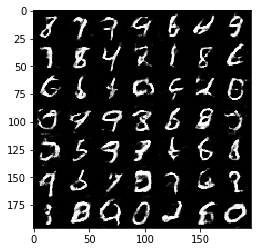

Epoch 2/2... Discriminator Loss: 1.1569... Generator Loss: 0.9061
Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.8136
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.6260
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 0.8187
Epoch 2/2... Discriminator Loss: 1.5163... Generator Loss: 0.5547
Epoch 2/2... Discriminator Loss: 1.5983... Generator Loss: 2.4614
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.7939
Epoch 2/2... Discriminator Loss: 1.1940... Generator Loss: 0.7758
Epoch 2/2... Discriminator Loss: 2.0773... Generator Loss: 0.3133
Epoch 2/2... Discriminator Loss: 1.0520... Generator Loss: 1.1290


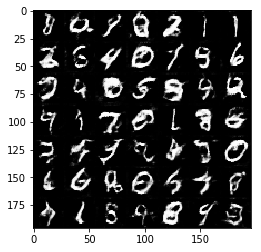

Epoch 2/2... Discriminator Loss: 0.8833... Generator Loss: 1.6120
Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 1.1497
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 1.5674
Epoch 2/2... Discriminator Loss: 1.7795... Generator Loss: 0.4351
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 1.2843
Epoch 2/2... Discriminator Loss: 0.9901... Generator Loss: 1.0341
Epoch 2/2... Discriminator Loss: 1.5445... Generator Loss: 0.5475
Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 1.2846
Epoch 2/2... Discriminator Loss: 1.1144... Generator Loss: 0.9312
Epoch 2/2... Discriminator Loss: 1.1673... Generator Loss: 1.4422


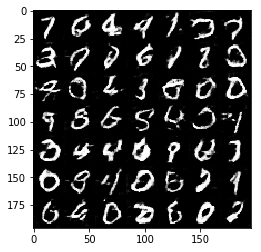

Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 1.8914
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 1.2179
Epoch 2/2... Discriminator Loss: 1.0508... Generator Loss: 1.5056
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 1.4647
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 0.9098
Epoch 2/2... Discriminator Loss: 1.5624... Generator Loss: 0.4830
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.2849
Epoch 2/2... Discriminator Loss: 0.9176... Generator Loss: 1.4909
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 0.7736
Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 0.8543


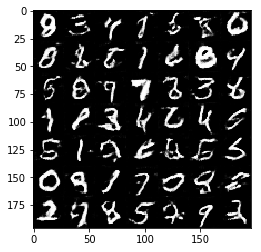

Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.6590
Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 0.9468
Epoch 2/2... Discriminator Loss: 1.4880... Generator Loss: 0.5216
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 1.9694
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.4848
Epoch 2/2... Discriminator Loss: 1.2100... Generator Loss: 0.8900
Epoch 2/2... Discriminator Loss: 2.2958... Generator Loss: 3.1703
Epoch 2/2... Discriminator Loss: 1.1033... Generator Loss: 1.6288
Epoch 2/2... Discriminator Loss: 0.8913... Generator Loss: 1.1885
Epoch 2/2... Discriminator Loss: 1.4854... Generator Loss: 2.5199


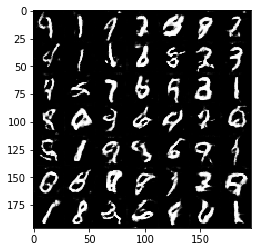

Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 0.9531
Epoch 2/2... Discriminator Loss: 0.9431... Generator Loss: 1.6165
Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 1.9011
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 1.0927
Epoch 2/2... Discriminator Loss: 1.0692... Generator Loss: 1.1058
Epoch 2/2... Discriminator Loss: 0.8264... Generator Loss: 1.7345
Epoch 2/2... Discriminator Loss: 1.5379... Generator Loss: 3.1406
Epoch 2/2... Discriminator Loss: 0.8425... Generator Loss: 1.4858
Epoch 2/2... Discriminator Loss: 1.2866... Generator Loss: 0.7565
Epoch 2/2... Discriminator Loss: 0.8953... Generator Loss: 1.6693


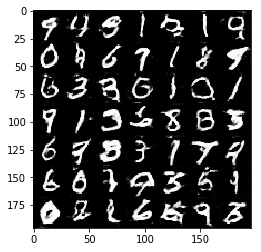

Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.7342
Epoch 2/2... Discriminator Loss: 1.1233... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 1.0814
Epoch 2/2... Discriminator Loss: 1.4105... Generator Loss: 0.6006
Epoch 2/2... Discriminator Loss: 0.9613... Generator Loss: 1.3930
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.8238
Epoch 2/2... Discriminator Loss: 1.0365... Generator Loss: 0.9487
Epoch 2/2... Discriminator Loss: 1.0901... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 2.6676
Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 1.2988


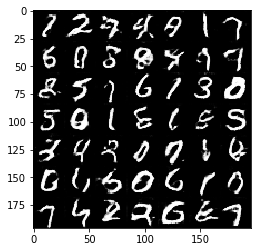

Epoch 2/2... Discriminator Loss: 0.8743... Generator Loss: 1.3178
Epoch 2/2... Discriminator Loss: 1.1252... Generator Loss: 0.8382
Epoch 2/2... Discriminator Loss: 0.8672... Generator Loss: 1.6721
Epoch 2/2... Discriminator Loss: 0.9528... Generator Loss: 1.3983
Epoch 2/2... Discriminator Loss: 0.9755... Generator Loss: 1.5109
Epoch 2/2... Discriminator Loss: 0.8605... Generator Loss: 2.1860
Epoch 2/2... Discriminator Loss: 1.6576... Generator Loss: 0.4807
Epoch 2/2... Discriminator Loss: 1.2024... Generator Loss: 1.6686
Epoch 2/2... Discriminator Loss: 1.0831... Generator Loss: 1.1657
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 1.4454


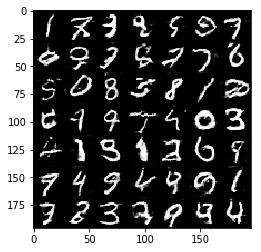

Epoch 2/2... Discriminator Loss: 1.1747... Generator Loss: 1.6704
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 1.2807
Epoch 2/2... Discriminator Loss: 1.0607... Generator Loss: 0.9562
Epoch 2/2... Discriminator Loss: 0.9616... Generator Loss: 1.1683
Epoch 2/2... Discriminator Loss: 1.0393... Generator Loss: 1.7149
Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 0.7572
Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 1.6248
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 1.9494
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.5172... Generator Loss: 0.4946


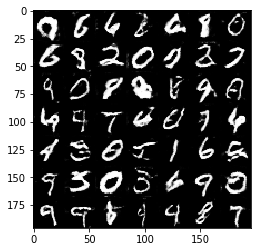

Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 2.3988
Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 0.8665
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 0.8383
Epoch 2/2... Discriminator Loss: 1.1664... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 1.8399... Generator Loss: 0.4747
Epoch 2/2... Discriminator Loss: 1.3497... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 0.7907


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

##### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.6497... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 4.7450... Generator Loss: 24.9588
Epoch 1/1... Discriminator Loss: 1.8527... Generator Loss: 5.6655
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 2.0320
Epoch 1/1... Discriminator Loss: 1.9405... Generator Loss: 3.8320
Epoch 1/1... Discriminator Loss: 3.2364... Generator Loss: 6.0128
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 1.2388
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 1.4511
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.5430


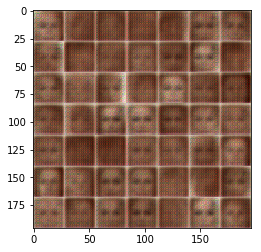

Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 1.7678
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 1.9506
Epoch 1/1... Discriminator Loss: 2.8058... Generator Loss: 0.1646
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 1.1860
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 1.2478
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 2.0559... Generator Loss: 0.3468
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 1.3200
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.9132


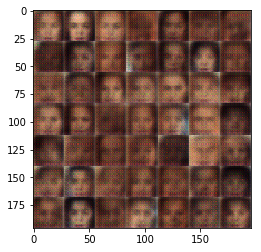

Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 3.0557
Epoch 1/1... Discriminator Loss: 1.6364... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.9358... Generator Loss: 0.4686
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 1.7852


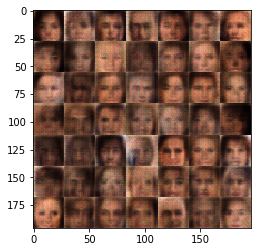

Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.5944
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.7879
Epoch 1/1... Discriminator Loss: 0.8457... Generator Loss: 1.6525
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.3515
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.4545
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.7595


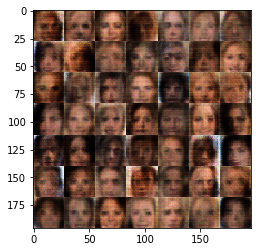

Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 2.5730
Epoch 1/1... Discriminator Loss: 2.5221... Generator Loss: 0.1650
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 2.7342


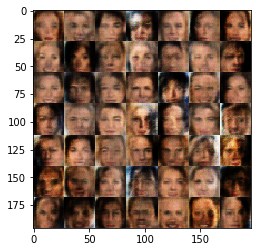

Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 3.1910
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.6087
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 2.5655
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 2.6360
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 3.0100
Epoch 1/1... Discriminator Loss: 0.4623... Generator Loss: 3.0001


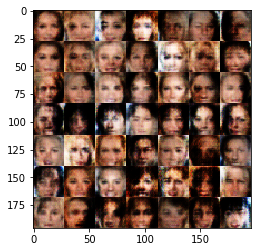

Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 2.0226
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 1.8361
Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 3.2432
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.7327
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.3717
Epoch 1/1... Discriminator Loss: 0.5940... Generator Loss: 1.7775
Epoch 1/1... Discriminator Loss: 1.6387... Generator Loss: 0.4228
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 0.8112


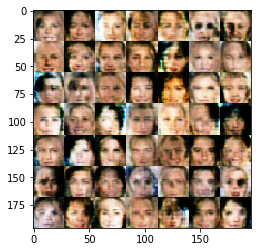

Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 2.4443
Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 2.0389
Epoch 1/1... Discriminator Loss: 0.6220... Generator Loss: 1.8219
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 4.3212
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.5641
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.3878
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 2.2156
Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 2.4900
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.6450


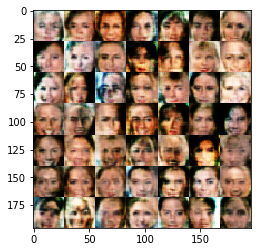

Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 2.9578
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 2.6676
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 2.1600
Epoch 1/1... Discriminator Loss: 0.5887... Generator Loss: 2.3473
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.4773


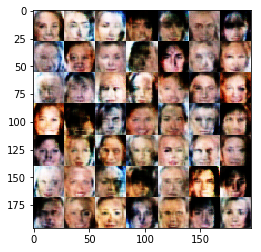

Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 1.9186
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 2.9598
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 1.7344
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 1.5710
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 2.1745... Generator Loss: 0.1780


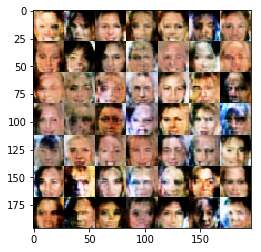

Epoch 1/1... Discriminator Loss: 2.8705... Generator Loss: 0.1025
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 3.6491
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.5676
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 0.4867... Generator Loss: 2.6659
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 3.6903
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 1.9913
Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.3756


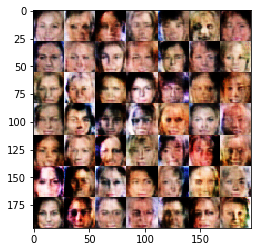

Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 2.5929
Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 3.2315
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 3.8979
Epoch 1/1... Discriminator Loss: 0.4814... Generator Loss: 3.9697
Epoch 1/1... Discriminator Loss: 0.4629... Generator Loss: 2.9640
Epoch 1/1... Discriminator Loss: 1.6122... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.8540


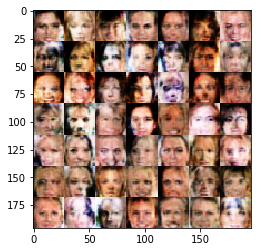

Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 1.7528
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 1.6784
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 1.1160
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 1.3497
Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 1.3941
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.2825


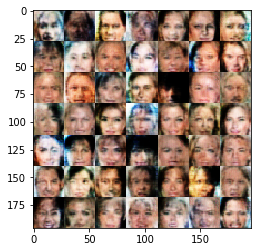

Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.3012
Epoch 1/1... Discriminator Loss: 1.9289... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 1.6155
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 1.2225
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.5401
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.4359
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 1.1422


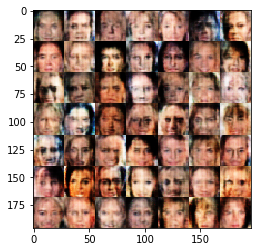

Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 1.8120
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.9602
Epoch 1/1... Discriminator Loss: 2.3776... Generator Loss: 2.6132
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 3.0842
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 1.5622
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 2.4565
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.5083
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.5839


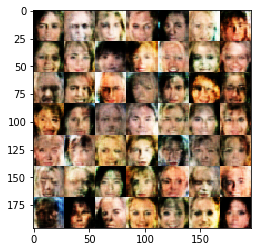

Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 2.7499
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.2375
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 1.6715
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 2.5792
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 4.6039
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 2.1238
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.5571
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 2.2598


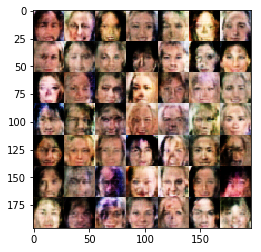

Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 1.6102
Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 2.0945
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 2.5090
Epoch 1/1... Discriminator Loss: 1.7811... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.0497


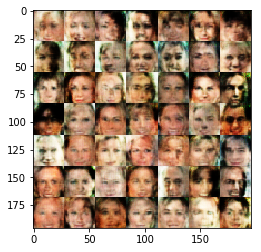

Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 1.2922
Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 2.3702
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.4770
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.8677
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 0.6709... Generator Loss: 1.8645


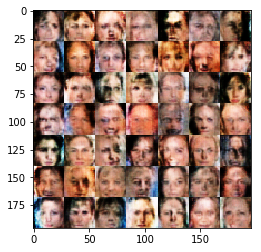

Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.4591
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 3.6475
Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 3.0349
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 1.6981
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 2.4338
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 2.7194
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 2.6304
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.6777


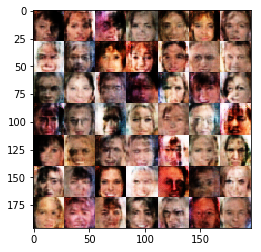

Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.9679
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 1.5247
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 1.9127
Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 1.9034
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 1.9988
Epoch 1/1... Discriminator Loss: 3.2464... Generator Loss: 3.8384
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 1.5000
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.5013
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.5510


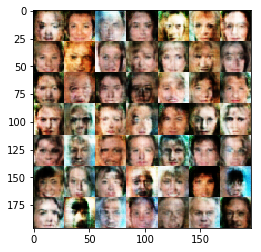

Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 2.1981
Epoch 1/1... Discriminator Loss: 1.8082... Generator Loss: 0.3583
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.3694
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 3.3660
Epoch 1/1... Discriminator Loss: 0.6785... Generator Loss: 1.5705
Epoch 1/1... Discriminator Loss: 1.9089... Generator Loss: 0.3508
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 3.0669


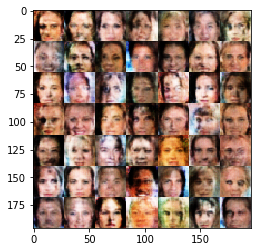

Epoch 1/1... Discriminator Loss: 1.6759... Generator Loss: 3.4083
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 1.7660
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 1.3735
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 1.7197
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 1.7283
Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 2.0195
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.7070


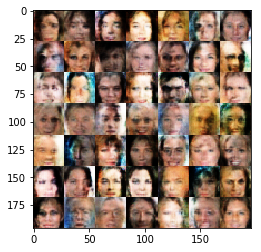

Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.5075
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 0.7670... Generator Loss: 1.9161
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.2476
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 2.5742
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 1.8261
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 1.4542
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.5638


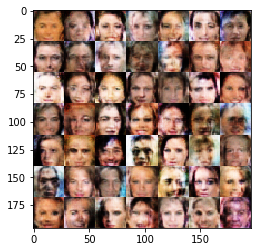

Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.3398
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.6449
Epoch 1/1... Discriminator Loss: 1.8501... Generator Loss: 2.6680
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.6600
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.2106
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.4573
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 2.0964
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 1.8594
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 2.9166


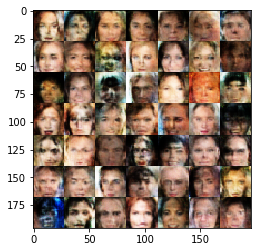

Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 2.9559
Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 1.4844
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 1.2996
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.5237
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 2.0769
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.7998
Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 2.2435
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 1.9456
Epoch 1/1... Discriminator Loss: 0.6718... Generator Loss: 2.3760


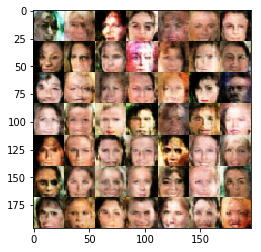

Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 1.4747
Epoch 1/1... Discriminator Loss: 0.7252... Generator Loss: 1.7471
Epoch 1/1... Discriminator Loss: 1.9338... Generator Loss: 0.3416
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 1.7033
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.7721
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 2.5057
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 1.5781
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.9688
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 0.8377


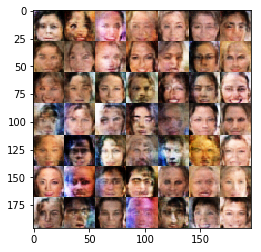

Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 2.3438
Epoch 1/1... Discriminator Loss: 1.8881... Generator Loss: 0.3653
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 2.9003
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.5065
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 2.1815
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.9649
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 2.1834
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 1.7935
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 1.4398


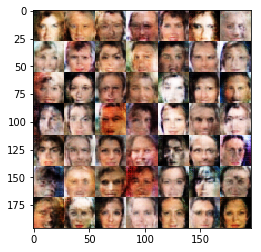

Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.6024
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.6632
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 2.5230
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 1.3539
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 2.1995
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 2.2133


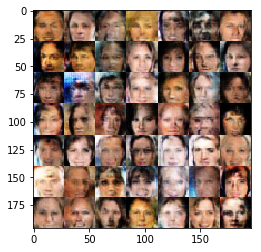

Epoch 1/1... Discriminator Loss: 1.8825... Generator Loss: 0.4031
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 2.3840
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.4282
Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 1.5673
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 2.1937
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 1.5239
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 3.1091
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.6894


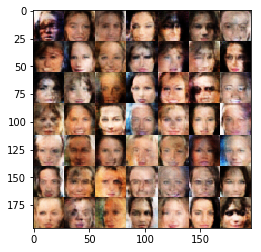

Epoch 1/1... Discriminator Loss: 0.7865... Generator Loss: 1.2118
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.5447
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.5614... Generator Loss: 3.6001
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 1.5851
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 1.1734


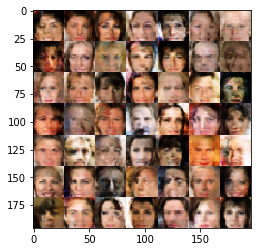

Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 2.3879
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 1.8942
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 2.2325
Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.4681
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 2.0228
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.6634
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.6281
Epoch 1/1... Discriminator Loss: 1.6649... Generator Loss: 3.4312


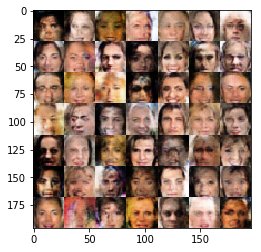

Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 3.3310
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.9631
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.8450
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.0408


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.